**Building recommender system using collaborative filtering approach**

The following code:

* Transforms data from transactions.csv into a (user, article, numbers_of_pusrchases) cllection which is the requirded form to feed to ALS model in PySpark.

* Fits the model on the data to produce 10d feature vectors 

* Produces and plots top k recommendations

Input data limited to 100000 transactions 

In [7]:
!pip install pyspark

     |████████████████████████████████| 310.8 MB 24 kB/s              
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 200 kB 61.0 MB/s            
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285411 sha256=1ffb71a02bffdadb1a53ef3a3339b392e611d14e1abefe41158f73e1d3ff49ef
  Stored in directory: /root/.cache/pip/wheels/b7/8e/8f/ba5d017af5f502964eb1358e1d496a8519de1645936b01810e
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.4
    Uninstalling py4j-0.10.9.4:
      Successfully uninstalled py4j-0.10.9.4


In [8]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql import Row

spark = SparkSession.builder.appName('Recommendations').getOrCreate()

lines = spark.read.options(header=True).csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
df = lines.drop('sales_channel_id').drop('price').drop('t_dat').limit(100000)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/15 12:56:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/conda/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [9]:
# get unique customer and article ids so you can map them to integers as per pyspark requirements for ALS model
unique_customers = df.select('customer_id').distinct()
unique_articles = df.select('article_id').distinct()

In [10]:
#Create a list of Row objects that map each custmoer id to a unique integer
customer_id_mapping = []
for i, c in enumerate(unique_customers.collect()):
    customer_id_mapping.append(Row(c['customer_id'], i))

In [11]:
#Create a list of Row objects that map each article id to a unique integer

article_id_mapping = []
for i, c in enumerate(unique_articles.collect()):
    article_id_mapping.append(Row(c['article_id'], i))

In [12]:
customer_map = spark.createDataFrame(customer_id_mapping, ['customer_id', 'int_customer_id'])

In [13]:
article_map = spark.createDataFrame(article_id_mapping, ['article_id', 'int_article_id'])

In [14]:
map_df = df.join(customer_map, 'customer_id').join(article_map, on='article_id')

In [15]:
map_df.show()

+----------+--------------------+---------------+--------------+
|article_id|         customer_id|int_customer_id|int_article_id|
+----------+--------------------+---------------+--------------+
|0541518023|000058a12d5b43e67...|              0|             1|
|0663713001|000058a12d5b43e67...|              0|             0|
|0505221001|00007d2de826758b6...|              1|             6|
|0685687001|00007d2de826758b6...|              1|             5|
|0685687004|00007d2de826758b6...|              1|             4|
|0685687003|00007d2de826758b6...|              1|             3|
|0505221004|00007d2de826758b6...|              1|             2|
|0688873011|00083cda041544b2f...|              2|            11|
|0688873020|00083cda041544b2f...|              2|            10|
|0598859003|00083cda041544b2f...|              2|             9|
|0501323011|00083cda041544b2f...|              2|             8|
|0688873012|00083cda041544b2f...|              2|             7|
|0529841001|0008968c0d451

In [16]:
#get number of purchases of each item by each users 
#which will be treated as a rating of customers liking of this specific article

user_item = map_df.groupby(['int_customer_id', 'int_article_id']).count()

In [17]:
user_item.show(5)

+---------------+--------------+-----+
|int_customer_id|int_article_id|count|
+---------------+--------------+-----+
|              4|            19|    2|
|            123|           357|    1|
|            141|           414|    1|
|            245|           699|    1|
|            307|           825|    1|
+---------------+--------------+-----+
only showing top 5 rows



In [18]:
# user_item.write.parquet("./user_item_matrix.parquet")

In [19]:
(training, test) = user_item.randomSplit([0.8, 0.2])

In [20]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="int_customer_id", itemCol="int_article_id", ratingCol="count",
          coldStartStrategy="drop")
model = als.fit(training)

23/08/15 12:57:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/15 12:57:40 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [21]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="count",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.3128716826638267


In [22]:
def get_rcmnds(k=6):
    # Generate top k recommendations for a specified set of customers
    users = user_item.select(als.getUserCol()).distinct().limit(1)
    userSubsetRecs = model.recommendForUserSubset(users, k)
    # Generate top k customer recommendations for a specified set of articles
    movies = user_item.select(als.getItemCol()).distinct().limit(1)
    movieSubSetRecs = model.recommendForItemSubset(movies, k)

    cid = userSubsetRecs.collect()[0][0]
    aids = []
    for row in userSubsetRecs.collect()[0][1]:
        aids.append(row['int_article_id'])

    rcmnds = article_map.filter(article_map.int_article_id.isin(aids)).toPandas().article_id.values

    prev_items_int = user_item.filter(user_item.int_customer_id == cid).toPandas().int_article_id.values.tolist()

    prev_items = article_map.filter(article_map.int_article_id.isin(prev_items_int)).toPandas().article_id.values
    
    return rcmnds, prev_items

In [23]:
rcmnds, prev_items = get_rcmnds()

In [31]:
import matplotlib.pyplot as plt
path = "../input/h-and-m-personalized-fashion-recommendations/images"
def plot_prev(prev_items):
    k = len(prev_items)
    fig = plt.figure(figsize=(15, 10))
    for item, i in zip(prev_items, range(2, k+1)):
        item = str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, k, i)
        plt.imshow(image)
        
def plot_rcmnd(rcmnds):
    k = len(rcmnds)
    fig = plt.figure(figsize=(15, 10))
    for item, i in zip(rcmnds, range(2, k+1)):
        
        item = str(item)
        sub = item[:3]
        image = path + "/"+ sub + "/"+ item +".jpg"
        image = plt.imread(image)
        fig.add_subplot(1, k, i)
        plt.imshow(image)

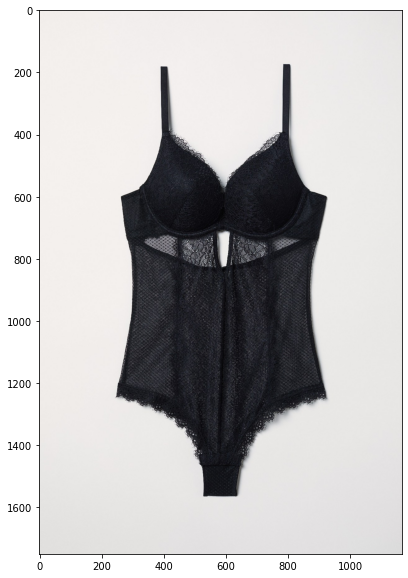

In [32]:
plot_prev(prev_items)

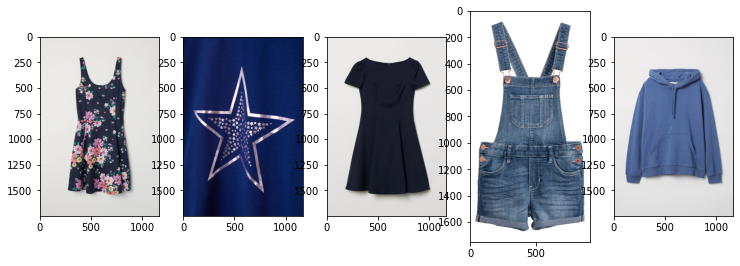

In [26]:
plot_rcmnd(rcmnds)